<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-MODULE3-AdaptiveWindowAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Loaded baseline error + window distribution.
   Error median=0.001153, MAD=0.000440
   Window mean=67.258, std=22.841
✅ Loaded MLP model from /content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_10Sec.keras
AdaptiveWindowAgent adaptive_window_agent initialized
✅ Loaded NSP LSTM next-step predictor
Loading data...
Loaded TEST: (1000, 100, 12), labels: (1000,)

Starting real-time forecasting...
[001] win=35 | mse=0.002588 | FDS=3.263 | FDI=0.000 | WSS=-1.412 | WDI=0.000 | event=None
[002] win=41 | mse=0.001892 | FDS=1.679 | FDI=0.000 | WSS=-1.150 | WDI=0.000 | event=None
[003] win=45 | mse=0.001847 | FDS=1.577 | FDI=0.000 | WSS=-0.974 | WDI=0.000 | event=None
[004] win=86 | mse=0.001844 | FDS=1.570 | FDI=0.000 | WSS=0.821 | WDI=0.000 | event=None
[005] win=74 | mse=0.002139 | FDS=2.243 | FDI=0.000 | WSS=0.295 | WDI=0.000 | event=None
[006] win=67 | mse=0.001856 | FDS=1.598 | FDI=0.000 | WSS=-0.011 | WDI=0.000 | event=None
[007] win=74 | mse=0.001589 | FDS=0.991 | FDI=0

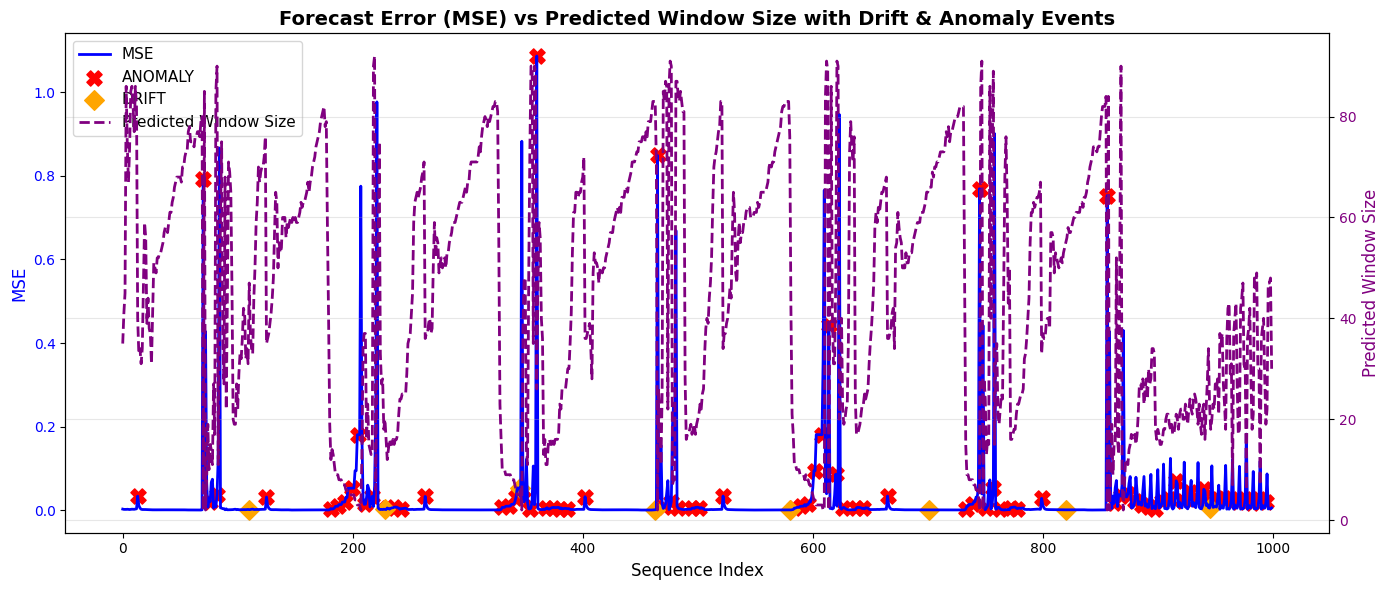

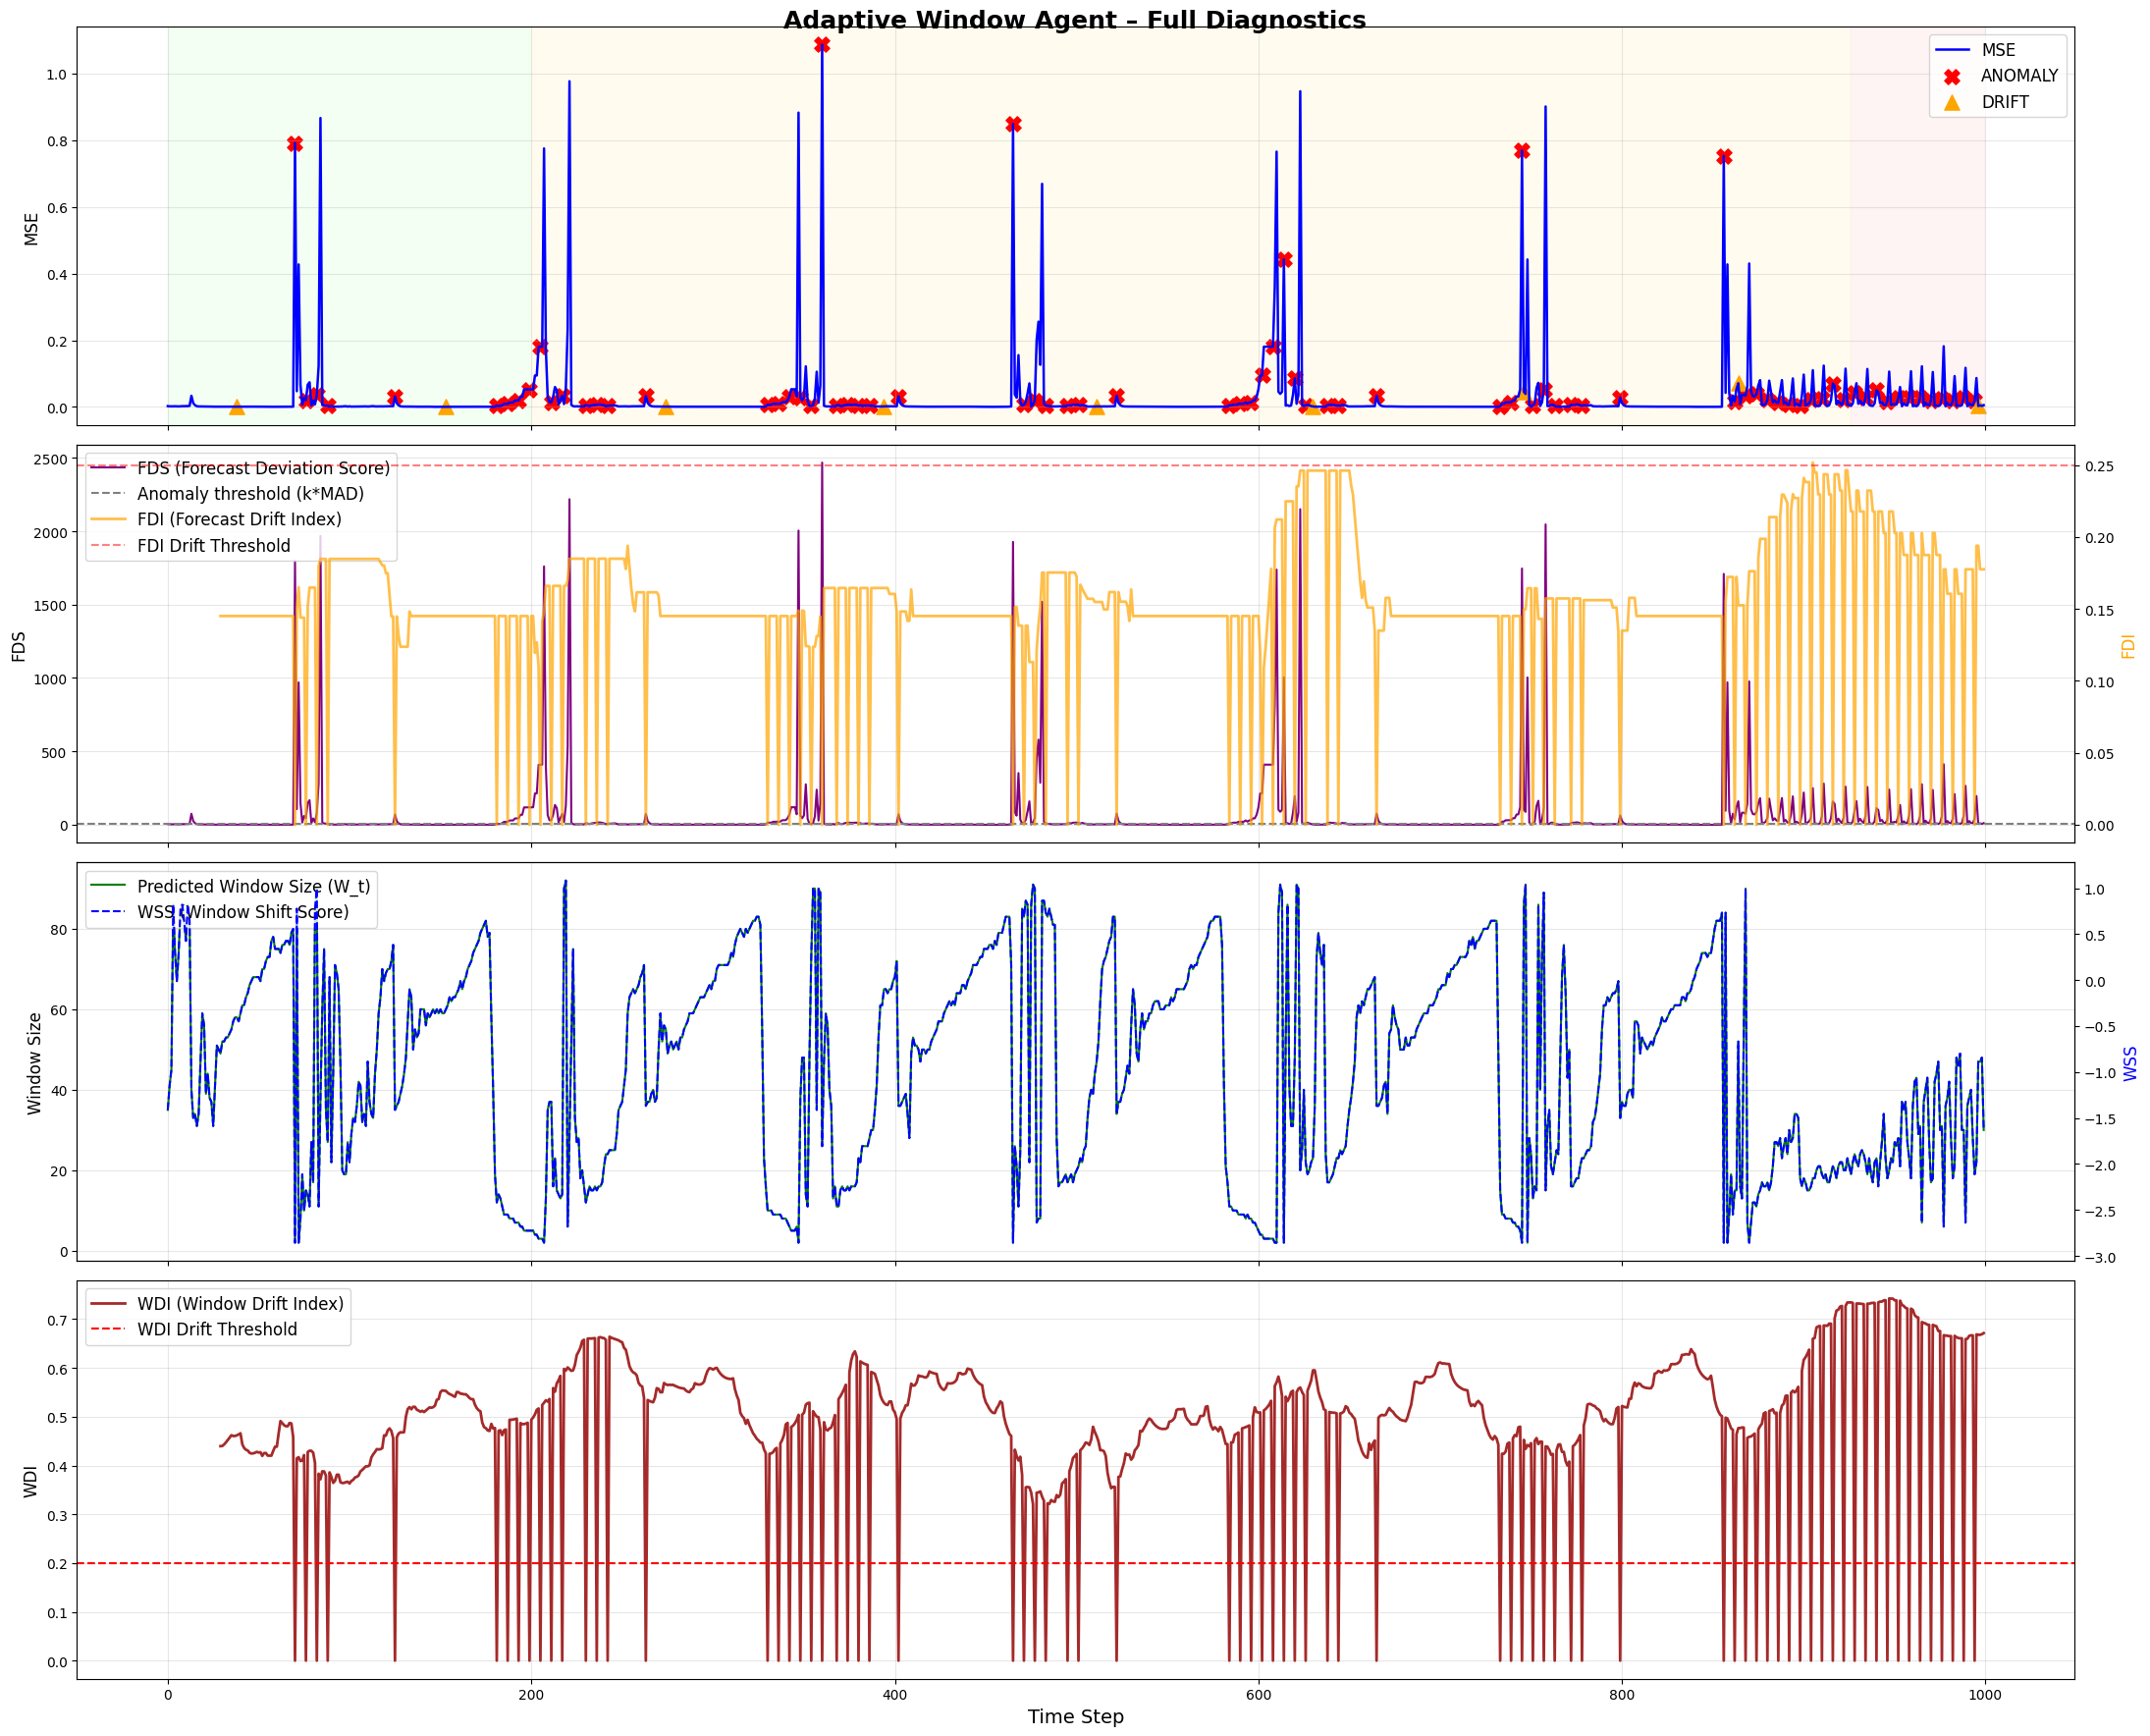

✅ Performance state saved to real_data_test_results.json
Saved test results.


In [1]:
import numpy as np
import pandas as pd
import pickle
import json
import os
from collections import deque
from typing import Dict, Any
import datetime as dt
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.vector_ar.var_model import VAR
import keras
import tensorflow as tf
import warnings
from scipy.spatial.distance import jensenshannon
warnings.filterwarnings('ignore')

logger = logging.getLogger(__name__)


class AdaptiveWindowAgent:
    """
    Adaptive Window Agent:
    - Predicts window size using MLP
    - Evaluates forecast with RF/persistence
    - Computes:
        * FDS: Forecast Deviation Score (normalized error)
        * FDI: Forecast Drift Index (JSD over FDS distribution)
        * WSS: Window Shift Score (normalized window size)
        * WDI: Window Drift Index (JSD over window size distribution)
    - Detects anomaly (local) + drift (regime) events.
    """

    def __init__(self, agent_id="adaptive_window_agent",
                 model_path=None, checkpoint_path=None):
        self.agent_id = agent_id
        self.model_path = model_path or "/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_10Sec.keras"

        self.baseline_path = "/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_baseline.pkl"
        self.checkpoint_path = checkpoint_path

        # --------------------------------------------------
        # Core model
        # --------------------------------------------------
        self.model = None
        self.transformer = StandardScaler()
        self.transformer_fitted = False
        self.is_model_loaded = False

        # Baseline error stats (median / MAD) – filled from baseline file
        self.rolling_stats = {
            'median': 0.0,
            'mad': 1.0,
        }

        # --------------------------------------------------
        # Metrics memory
        # --------------------------------------------------
        # Raw error
        self.error_memory = deque(maxlen=300)     # long-term errors
        self.recent_errors = deque(maxlen=50)     # kept for backward compat (not central now)

        # FDS (Forecast Deviation Score) history
        self.fds_memory = deque(maxlen=300)
        self.recent_fds = deque(maxlen=50)

        # Window history
        self.window_memory = deque(maxlen=300)
        self.recent_windows = deque(maxlen=50)

        # Last-step metrics (for returning)
        self.last_fds = 0.0
        self.last_fdi = 0.0
        self.last_wss = 0.0
        self.last_wdi = 0.0

        # Baseline distributions
        self.baseline_errors = None
        self.baseline_fds = None
        self.baseline_windows = None
        self.window_mean = 50.0    # a reasonable mid value
        self.window_std = 10.0     # non-zero, avoids div-by-zero

        # Optional histogram bins stored in baseline
        self.window_hist_bins = None
        self.window_hist_counts = None

        # Debug flag (OFF by default)
        self.debug = False

        # --------------------------------------------------
        # Anomaly / drift settings
        # --------------------------------------------------
        self.threshold_k = 3.0
        self.anomaly_cooldown = 0
        self.anomaly_cooldown_steps = 5

        # Drift detection
        self.drift_threshold = 0.25          # for FDI (JSD over FDS)
        self.window_drift_threshold = 0.20   # for WDI (JSD over window sizes)
        self.consecutive_drift_votes = 0
        self.drift_cooldown = 0
        self.drift_votes_required = 10
        self.drift_cooldown_steps = 100

        # --------------------------------------------------
        # Retraining buffer (unchanged)
        # --------------------------------------------------
        self.performance_stats = {
            'total_predictions': 0,
            'avg_mse': 0.0,
            'avg_mae': 0.0,
            'last_retrain_time': None,
            'drift_events': 0,
            'anomaly_events': 0,
            'retraining_events': 0
        }

        self.retraining_data = {
            'x_buffer': deque(maxlen=10000),
            'y_buffer': deque(maxlen=10000)
        }

        # --------------------------------------------------
        # Prediction history (for reporting)
        # --------------------------------------------------
        self.prediction_history = deque(maxlen=1000)
        self.mse_history = deque(maxlen=200)
        self.mae_history = deque(maxlen=200)

        # --------------------------------------------------
        # Load baseline (errors + windows)
        # --------------------------------------------------
        self._load_baseline()

        # --------------------------------------------------
        # Load model last
        # --------------------------------------------------
        self.load_model()
        print(f"AdaptiveWindowAgent {self.agent_id} initialized")

        # --------------------------------------------------
        # Load NSP (Next-Step Predictor)
        # --------------------------------------------------
        self.nsp_model_path = "/content/drive/MyDrive/PHD/2025/NSP_LSTM_next_step.keras"
        self.nsp_model = keras.models.load_model(self.nsp_model_path)
        print("✅ Loaded NSP LSTM next-step predictor")

    # =================== BASELINE LOADING ===================

    def _load_baseline(self):
        """
        Load baseline stats:
          - baseline_errors, median, mad
          - baseline_windows, window_mean, window_std
          - optional histogram bins/counts for windows
        """
        if os.path.exists(self.baseline_path):
            with open(self.baseline_path, "rb") as f:
                base = pickle.load(f)

            # Error baseline
            self.baseline_errors = np.array(base["baseline_errors"])
            self.rolling_stats["median"] = base["median"]
            self.rolling_stats["mad"] = base["mad"]

            # Precompute baseline FDS distribution
            med = self.rolling_stats["median"]
            mad = self.rolling_stats["mad"] if self.rolling_stats["mad"] > 0 else 1e-6
            self.baseline_fds = (self.baseline_errors - med) / (mad + 1e-8)

            # Window baseline (may or may not exist)
            if "baseline_windows" in base:
                self.baseline_windows = np.array(base["baseline_windows"])
                self.window_mean = float(base.get("window_mean", np.mean(self.baseline_windows)))
                self.window_std = float(base.get("window_std", np.std(self.baseline_windows) + 1e-8))
                self.window_hist_bins = np.array(base.get("window_hist_bins", [])) if "window_hist_bins" in base else None
                self.window_hist_counts = np.array(base.get("window_hist_counts", [])) if "window_hist_counts" in base else None
            else:
                self.baseline_windows = None
                self.window_mean = 0.0
                self.window_std = 1.0
                self.window_hist_bins = None
                self.window_hist_counts = None

            print("✅ Loaded baseline error + window distribution.")
            print(f"   Error median={self.rolling_stats['median']:.6f}, MAD={self.rolling_stats['mad']:.6f}")
            if self.baseline_windows is not None:
                print(f"   Window mean={self.window_mean:.3f}, std={self.window_std:.3f}")
        else:
            print("⚠️ No baseline found. Using live history only.")
            self.baseline_errors = None
            self.baseline_fds = None
            self.baseline_windows = None

    # =================== MODEL LOADING ===================

    def load_model(self):
        try:
            if os.path.exists(self.model_path):
                self.model = keras.models.load_model(self.model_path)
                self.is_model_loaded = True
                print(f"✅ Loaded MLP model from {self.model_path}")

                # Try to load transformer
                transformer_path = self.model_path.replace('.keras', '_transformer.pkl')
                if os.path.exists(transformer_path):
                    with open(transformer_path, 'rb') as f:
                        self.transformer = pickle.load(f)
                    self.transformer_fitted = True
                else:
                    # Fit transformer from true window labels
                    y_original = np.load(
                        "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated-data-true-window2.npy"
                    )
                    self.transformer.fit(y_original.reshape(-1, 1))
                    self.transformer_fitted = True
                    with open(transformer_path, 'wb') as f:
                        pickle.dump(self.transformer, f)
                    print("⚠️ No transformer found, fitted a new one.")
            else:
                print(f"❌ Model not found at {self.model_path}")
        except Exception as e:
            print(f"❌ Error loading model: {e}")

    # =================== FORECAST EVALUATION ===================

    def evaluate_forecast_performance(self, sequence_3d, predicted_window, n_future=1):
        try:
            seq = np.asarray(sequence_3d)
            T, F = seq.shape

            W = int(predicted_window)
            if W < 2:
                W = 2
            if W > T - n_future - 1:
                W = max(2, T - n_future - 1)

            # --- Prepare NSP input ---
            window = seq[-W:-n_future, :]   # shape (W-1, F)
            x = window[np.newaxis, ...]      # shape (1, W-1, F)

            # --- NSP prediction ---
            y_pred = self.nsp_model.predict(x, verbose=0)[0]  # (F,)
            y_true = seq[-n_future, :]                        # (F,)

            mse = float(np.mean((y_true - y_pred) ** 2))
            mae = float(np.mean(np.abs(y_true - y_pred)))

            return {
                "mse": mse,
                "mae": mae,
                "forecast_success": True,
                "actual_values": y_true.tolist(),
                "predicted_values": y_pred.tolist(),
                "window_size_used": W,
                "method": "NSP_LSTM"
            }

        except Exception as e:
            return {
                "mse": 9999.0,
                "mae": 9999.0,
                "forecast_success": False,
                "error": str(e),
                "method": "NSP_LSTM"
            }

    # =================== PERSISTENCE FALLBACK ===================

    def _persistence_forecast(self, seq, target_sensor_index, n_future):
        """
        Persistence fallback for RF evaluation.
        Last-value-carried-forward for target sensor.
        """
        try:
            seq = np.asarray(seq)
            if len(seq) < 2:
                return {
                    'mse': 9999,
                    'mae': 9999,
                    'forecast_success': False,
                    'error': 'Sequence too short',
                    'method': 'Persistence'
                }

            last_value = seq[-1, target_sensor_index]
            predicted_vals = [last_value]
            actual = [seq[-1, target_sensor_index]]

            mse = 0.0
            mae = 0.0

            return {
                'mse': mse,
                'mae': mae,
                'forecast_success': True,
                'actual_values': actual,
                'predicted_values': predicted_vals,
                'target_sensor_index': target_sensor_index,
                'method': 'Persistence',
                'note': 'persistence_fallback'
            }

        except Exception as e:
            return {
                'mse': 9999,
                'mae': 9999,
                'forecast_success': False,
                'error': str(e),
                'method': 'Persistence',
                'note': 'persistence_fallback_failed'
            }

    # =================== PREDICTION PIPELINE ===================

    def predict_window_size(self, feature_vector, sequence_3d):
        """
        Main entrypoint:
          - Predict window W_t
          - Evaluate forecast error e_t
          - Compute FDS (S_t) and WSS (Z_t)
          - Update drift/anomaly logic (FDI, WDI, events)
          - Return full metrics packet
        """
        if not self.is_model_loaded:
            return {'predicted_window': 20, 'error': "Model not loaded"}

        try:
            if feature_vector.ndim == 1:
                feature_vector = feature_vector.reshape(1, -1)

            pred_raw = self.model.predict(feature_vector, verbose=0)

            if self.transformer_fitted:
                predicted_window = int(round(self.transformer.inverse_transform(pred_raw)[0, 0]))
            else:
                predicted_window = int(round(pred_raw[0, 0]))

            # ----------------------------------------
            # WINDOW CLAMP — HARD SAFETY FIX
            # ----------------------------------------
            # Prevent negative, zero, or extreme window sizes
            predicted_window = max(2, predicted_window)        # lower bound

            # Forecast evaluation
            forecast_metrics = self.evaluate_forecast_performance(sequence_3d, predicted_window, n_future=1)

            fds = None
            wss = None

            if forecast_metrics.get("forecast_success", False):
                mse = forecast_metrics["mse"]
                mae = forecast_metrics["mae"]

                # Basic stats
                self.mse_history.append(mse)
                self.mae_history.append(mae)
                self.error_memory.append(mse)

                self.performance_stats['total_predictions'] += 1
                self.performance_stats['avg_mse'] = float(np.mean(self.mse_history))
                self.performance_stats['avg_mae'] = float(np.mean(self.mae_history))

                # ---------- Forecast Deviation Score (FDS) ----------
                baseline_median = self.rolling_stats["median"]
                baseline_mad = self.rolling_stats["mad"] if self.rolling_stats["mad"] > 0 else 1e-6
                fds = (mse - baseline_median) / (baseline_mad + 1e-8)
                fds = float(fds) if fds is not None and not np.isnan(fds) else 0.0


                self.last_fds = fds
                self.fds_memory.append(fds)
                self.recent_fds.append(fds)

                # ---------- Window Shift Score (WSS) ----------
                if self.baseline_windows is not None and self.window_std > 0:
                    wss = (predicted_window - self.window_mean) / (self.window_std + 1e-8)
                else:
                    wss = 0.0

                wss = float(wss)
                self.last_wss = wss
                self.window_memory.append(predicted_window)
                self.recent_windows.append(predicted_window)

            # Event (ANOMALY / DRIFT) + Drift indices
            event, sev, fdi, wdi = self._check_for_event()
            self.last_fdi = fdi
            self.last_wdi = wdi

            # Save history for reporting
            record = {
                'timestamp': dt.datetime.now(),
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'fds': self.last_fds,
                'wss': self.last_wss,
                'fdi': self.last_fdi,
                'wdi': self.last_wdi,
                'event_type': event,
                'severity': sev
            }
            self.prediction_history.append(record)

            return {
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'fds': self.last_fds,
                'fdi': self.last_fdi,
                'wss': self.last_wss,
                'wdi': self.last_wdi,
                'event_type': event,
                'severity': sev,
                'performance_stats': self.get_recent_performance()
            }
        except Exception as e:
            return {'predicted_window': 20, 'error': str(e)}

    # =================== EVENT LOGIC (ANOMALY + DRIFT) ===================

    def _check_for_event(self):
        """
        Event detection for the Adaptive Window Agent.

        - ANOMALY: deviation of last MSE from baseline (median + k * MAD)
        - DRIFT:
            * FDI: JSD between recent FDS distribution and baseline FDS
            * WDI: JSD between recent window distribution and baseline window distribution
        """
        # Require enough history
        if len(self.error_memory) < 30:
            return None, 0.0, None, None

        last_mse = float(self.error_memory[-1])
        live_errors = np.array(self.error_memory)

        # ---------- BASELINE STATS ----------
        if self.baseline_errors is not None and len(self.baseline_errors) > 10:
            base_errors = np.array(self.baseline_errors)
            baseline_median = np.median(base_errors)
            baseline_mad = np.median(np.abs(base_errors - baseline_median)) + 1e-8
        else:
            baseline_median = np.median(live_errors)
            baseline_mad = np.median(np.abs(live_errors - baseline_median)) + 1e-8

        # Update rolling_stats so other components can see latest baseline-ish values
        self.rolling_stats["median"] = baseline_median
        self.rolling_stats["mad"] = baseline_mad

        # ---------- LIVE STATS ----------
        live_median = np.median(live_errors)
        live_mad = np.median(np.abs(live_errors - live_median)) + 1e-8

        # ---------- ANOMALY THRESHOLD ----------
        baseline_threshold = baseline_median + self.threshold_k * baseline_mad
        live_threshold = live_median + self.threshold_k * live_mad

        anomaly_threshold = 0.8 * baseline_threshold + 0.2 * live_threshold

        is_anomaly = last_mse > anomaly_threshold

        if self.anomaly_cooldown > 0:
            self.anomaly_cooldown -= 1
            is_anomaly = False
        elif is_anomaly:
            self.anomaly_cooldown = self.anomaly_cooldown_steps

        if is_anomaly:
            severity = (last_mse - anomaly_threshold) / (baseline_mad + 1e-6)
            severity = float(severity)
            self.performance_stats["anomaly_events"] += 1
            if self.debug:
                print(f"[ANOMALY] mse={last_mse:.6f}, thr={anomaly_threshold:.6f}, sev={severity:.3f}")
            return "ANOMALY", severity, 0.0, 0.0

        # ---------- DRIFT (FDI + WDI) ----------
        fdi = None
        wdi = None

        # FDI: JSD over FDS distribution
        if self.baseline_fds is not None and len(self.recent_fds) >= 30:
            base_fds = np.asarray(self.baseline_fds)
            recent_fds = np.asarray(self.recent_fds)

            hist_base, bins = np.histogram(base_fds, bins=25, density=True)
            hist_recent, _ = np.histogram(recent_fds, bins=bins, density=True)

            hist_base = hist_base / (hist_base.sum() + 1e-12)
            hist_recent = hist_recent / (hist_recent.sum() + 1e-12)

            fdi = float(jensenshannon(hist_base + 1e-12, hist_recent + 1e-12))

        # WDI: JSD over window-size distribution
        if self.baseline_windows is not None and len(self.recent_windows) >= 30:
            base_win = np.asarray(self.baseline_windows)
            recent_win = np.asarray(self.recent_windows)

            hist_w_base, bins_w = np.histogram(base_win, bins=20, density=True)
            hist_w_recent, _ = np.histogram(recent_win, bins=bins_w, density=True)

            hist_w_base = hist_w_base / (hist_w_base.sum() + 1e-12)
            hist_w_recent = hist_w_recent / (hist_w_recent.sum() + 1e-12)

            wdi = float(jensenshannon(hist_w_base + 1e-12, hist_w_recent + 1e-12))

        # Decide drift if either index is high
        is_drift_fdi = fdi is not None and fdi > self.drift_threshold
        is_drift_wdi = wdi is not None and wdi > self.window_drift_threshold

        is_drift = is_drift_fdi or is_drift_wdi

        if self.drift_cooldown > 0:
            self.drift_cooldown -= 1
            is_drift = False
        else:
            if is_drift:
                self.consecutive_drift_votes += 1
            else:
                self.consecutive_drift_votes = 0

        if self.consecutive_drift_votes >= self.drift_votes_required:
            self.consecutive_drift_votes = 0
            self.drift_cooldown = self.drift_cooldown_steps
            self.performance_stats["drift_events"] += 1
            if self.debug:
                print(f"[DRIFT] FDI={fdi:.4f} WDI={wdi:.4f}")
            fdi = float(fdi) if fdi is not None else 0.0
            wdi = float(wdi) if wdi is not None else 0.0
            return "DRIFT", fdi, fdi, wdi

        # Make safe for printing
        fdi = float(fdi) if fdi is not None else 0.0
        wdi = float(wdi) if wdi is not None else 0.0

        return None, 0.0, fdi, wdi


    # =================== HELPERS ===================

    def get_recent_performance(self):
        all_preds = list(self.prediction_history)

        successful_predictions = [
            p for p in all_preds
            if p.get('forecast_metrics', {}).get('forecast_success', False)
        ]

        return {
            'total_predictions': len(all_preds),
            'successful_predictions': len(successful_predictions),
            'success_rate': len(successful_predictions) / max(len(all_preds), 1),
            'drift_events': self.performance_stats['drift_events'],
            'anomaly_events': self.performance_stats['anomaly_events'],
            'retraining_events': self.performance_stats['retraining_events'],
            'recent_mse': float(np.mean(list(self.mse_history)[-10:])) if self.mse_history else 0,
            'avg_mse': float(np.mean(self.mse_history)) if self.mse_history else 0,
            'recent_mae': float(np.mean(list(self.mae_history)[-10:])) if self.mae_history else 0,
            'avg_mae': float(np.mean(self.mae_history)) if self.mae_history else 0,
            'transformer_fitted': self.transformer_fitted,
            'last_fdi': self.last_fdi,
            'last_wdi': self.last_wdi,
        }

    def save_performance_state(self, filepath: str):
        """Save performance statistics + prediction history to JSON"""
        try:
            state = {
                'performance_stats': self.performance_stats.copy(),
                'prediction_history': list(self.prediction_history)[-100:],
                'mse_history': list(self.mse_history),
                'mae_history': list(self.mae_history),
                'transformer_fitted': self.transformer_fitted
            }
            with open(filepath, 'w') as f:
                json.dump(state, f, indent=2, default=str)
            print(f"✅ Performance state saved to {filepath}")
        except Exception as e:
            print(f"❌ Failed to save performance state: {e}")



# ==================== PLOTTING ====================
import matplotlib.pyplot as plt

def plot_target_sensor_forecasts(test_sequences, agent, target_idx=1):
    actual_vals = []
    forecast_vals = []
    event_points = []     # (timestep, event_type)
    timesteps_list = []

    # ====== COLLECT ALL FORECAST RESULTS ======
    for i, seq in enumerate(test_sequences):
        result = agent.predict_window_size(seq.flatten(), seq)
        fm = result.get("forecast_metrics", {})

        if not fm.get("forecast_success", False):
            continue

        # Extract actual & forecasted value for target sensor
        act = np.mean(fm["actual_values"])
        pred = np.mean(fm["predicted_values"])

        actual_vals.append(act)
        forecast_vals.append(pred)
        timesteps_list.append(i)

        # Track anomaly / drift events
        if result.get("event_type"):
            event_points.append((i, result["event_type"]))

    # ====== PREPARE DATA ======
    actual_vals = np.array(actual_vals)
    forecast_vals = np.array(forecast_vals)
    timesteps = np.array(timesteps_list)

    # ====== PLOT ======
    plt.figure(figsize=(14, 6))
    plt.plot(
        timesteps, actual_vals,
        label="Actual (Sensor V2)",
        marker="o", linestyle="-", color="blue"
    )
    plt.plot(
        timesteps, forecast_vals,
        label="Forecast (Sensor V2)",
        marker="x", linestyle="--", color="green"
    )

    # ====== MARK EVENTS WITH CLEAR LEGENDS ======
    anomaly_plotted = False
    drift_plotted = False

    for (t, ev) in event_points:
        if ev == "ANOMALY":
            plt.scatter(
                t, actual_vals[timesteps == t],
                color="red", marker="D", s=120,
                label="Anomaly" if not anomaly_plotted else ""
            )
            anomaly_plotted = True

        elif ev == "DRIFT":
            plt.scatter(
                t, actual_vals[timesteps == t],
                color="orange", marker="^", s=120,
                label="Drift" if not drift_plotted else ""
            )
            drift_plotted = True

    # ====== FINAL DECORATION ======
    plt.title("Forecast vs Actual for Sensor V2 (target_sensor_index = 1)")
    plt.xlabel("Sequence Index")
    plt.ylabel("Sensor Value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt
import numpy as np

def plot_mse_and_window(test_sequences, agent):
    mse_list = []
    window_list = []
    anomaly_points = []
    drift_points = []
    persistence_points = []

    for i, seq in enumerate(test_sequences):
        result = agent.predict_window_size(seq.flatten(), seq)
        fm = result.get("forecast_metrics", {})
        event = result.get("event_type", None)

        # Only count valid forecasts
        if not fm.get("forecast_success", False):
            mse_list.append(np.nan)
            window_list.append(np.nan)
            continue

        mse = fm.get("mse", np.nan)
        window = result.get("predicted_window", np.nan)

        mse_list.append(mse)
        window_list.append(window)

        # Event markers
        if event == "ANOMALY":
            anomaly_points.append((i, mse))
        elif event == "DRIFT":
            drift_points.append((i, mse))

        # Method markers
        if fm.get("method", "") == "Persistence":
            persistence_points.append((i, mse))

    # X-axis
    x = np.arange(len(mse_list))

    # ============= Create Plot =============
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # --- MSE Line ---
    ax1.plot(x, mse_list, label="MSE", color="blue", linewidth=2)
    ax1.set_xlabel("Sequence Index", fontsize=12)
    ax1.set_ylabel("MSE", color="blue", fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')

    # --- Anomalies ---
    if anomaly_points:
        ax1.scatter(
            [p[0] for p in anomaly_points],
            [p[1] for p in anomaly_points],
            color="red", marker="X", s=120, label="ANOMALY"
        )

    # --- Drift ---
    if drift_points:
        ax1.scatter(
            [p[0] for p in drift_points],
            [p[1] for p in drift_points],
            color="orange", marker="D", s=100, label="DRIFT"
        )

    # --- Persistence Fallback ---
    if persistence_points:
        ax1.scatter(
            [p[0] for p in persistence_points],
            [p[1] for p in persistence_points],
            color="green", marker="^", s=80, label="Persistence Used"
        )

    # --- Secondary axis for window size ---
    ax2 = ax1.twinx()
    ax2.plot(
        x, window_list,
        label="Predicted Window Size",
        color="purple",
        linewidth=2,
        linestyle="--"
    )
    ax2.set_ylabel("Predicted Window Size", color="purple", fontsize=12)
    ax2.tick_params(axis='y', labelcolor='purple')

    # Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=11)

    plt.title("Forecast Error (MSE) vs Predicted Window Size with Drift & Anomaly Events",
              fontsize=14, weight="bold")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


###########disgnostics#############

import matplotlib.pyplot as plt
import numpy as np

def plot_mse_drift_anomaly_with_labels(mse_list, drift_flags, anomaly_flags, labels, start=0, end=None):
    """
    Plots:
      - MSE curve
      - Drift detections
      - Anomaly detections
      - Label transitions (0=normal, 1=warning, 2=fault) as colored background bands
    """

    if end is None:
        end = len(mse_list)

    # Slice region
    mse = np.array(mse_list[start:end])
    drift_flags = np.array(drift_flags[start:end])
    anomaly_flags = np.array(anomaly_flags[start:end])
    labels = np.array(labels[start:end])

    x = np.arange(start, end)

    # -------------------- Plot --------------------
    plt.figure(figsize=(18, 5))

    # 1. Background color for labels
    for label_value, color, name in [
        (0, "#d0ffd0", "Normal"),
        (1, "#fff4c2", "Warning"),
        (2, "#ffd6d6", "Fault"),
    ]:
        regions = np.where(labels == label_value)[0]
        if len(regions) > 0:
            plt.axvspan(
                regions[0] + start,
                regions[-1] + start,
                color=color,
                alpha=0.3,
                label=f"Label {label_value} ({name})" if label_value in np.unique(labels) else ""
            )

    # 2. MSE curve
    plt.plot(x, mse, color="blue", linewidth=1.8, label="MSE")

    # 3. Drift events
    drift_idx = np.where(drift_flags == 1)[0]
    if len(drift_idx) > 0:
        plt.scatter(
            drift_idx + start, mse[drift_idx],
            color="orange", marker="^", s=120,
            label="DRIFT"
        )

    # 4. Anomaly events
    anomaly_idx = np.where(anomaly_flags == 1)[0]
    if len(anomaly_idx) > 0:
        plt.scatter(
            anomaly_idx + start, mse[anomaly_idx],
            color="red", marker="X", s=140,
            label="ANOMALY"
        )

    # -------------------- Labels --------------------
    plt.title("MLP/Forecast Agent – MSE vs Drift/Anomaly vs Labels", fontsize=14)
    plt.xlabel("Time Step")
    plt.ylabel("Forecast MSE")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_full_diagnostics(agent, mse_list, win_list, fds_list, fdi_list, wss_list, wdi_list,
                          drift_flags, anomaly_flags, labels,
                          start=0, end=None):
    """
    Four-panel diagnostic plot:
      1) MSE + anomaly + drift + labels
      2) FDS (Forecast Deviation Score) + FDI threshold
      3) Predicted window size + WSS
      4) WDI (Window Drift Index)
    """

    if end is None:
        end = len(mse_list)

    # Slice everything
    x = np.arange(start, end)
    mse = np.array(mse_list[start:end])
    win = np.array(win_list[start:end])
    fds = np.array(fds_list[start:end])
    fdi = np.array(fdi_list[start:end])
    wss = np.array(wss_list[start:end])
    wdi = np.array(wdi_list[start:end])
    drift_flags = np.array(drift_flags[start:end])
    anomaly_flags = np.array(anomaly_flags[start:end])
    labels = np.array(labels[start:end])

    # ===========================================
    # BUILD FIGURE
    # ===========================================
    fig, axs = plt.subplots(4, 1, figsize=(22, 18), sharex=True)
    fig.suptitle("Adaptive Window Agent – Full Diagnostics", fontsize=18, weight="bold")

    # ---------------------------------------------------
    # (1) MSE + events + label shading
    # ---------------------------------------------------
    ax = axs[0]

    # Background shading for labels (0 normal, 1 warn, 2 fault)
    for label_value, color, name in [
        (0, "#d0ffd0", "Normal"),
        (1, "#fff4c2", "Warning"),
        (2, "#ffd6d6", "Fault"),
    ]:
        idx = np.where(labels == label_value)[0]
        if len(idx) > 0:
            ax.axvspan(idx[0] + start, idx[-1] + start, color=color, alpha=0.25)

    ax.plot(x, mse, label="MSE", color="blue", linewidth=1.8)

    # Events
    ax.scatter(x[anomaly_flags == 1], mse[anomaly_flags == 1],
               color="red", marker="X", s=120, label="ANOMALY")
    ax.scatter(x[drift_flags == 1], mse[drift_flags == 1],
               color="orange", marker="^", s=120, label="DRIFT")

    ax.set_ylabel("MSE", fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)

    # ---------------------------------------------------
    # (2) FDS + Drift threshold (FDI)
    # ---------------------------------------------------
    ax = axs[1]
    ax.plot(x, fds, label="FDS (Forecast Deviation Score)", color="purple")

    # Optional: Highlight when FDI is above threshold
    if agent.drift_threshold:
        ax.axhline(agent.threshold_k, color="gray", linestyle="--",
                   label="Anomaly threshold (k*MAD)")

    # Drift detection marker when FDI rises
    ax2 = ax.twinx()
    ax2.plot(x, fdi, label="FDI (Forecast Drift Index)", color="orange", linewidth=2, alpha=0.7)
    ax2.axhline(agent.drift_threshold, color="red", linestyle="--", alpha=0.5,
                label="FDI Drift Threshold")

    ax.set_ylabel("FDS", fontsize=12)
    ax2.set_ylabel("FDI", fontsize=12, color="orange")
    ax.grid(alpha=0.3)

    # Legends merged
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, fontsize=12, loc="upper left")

    # ---------------------------------------------------
    # (3) Window size + WSS
    # ---------------------------------------------------
    ax = axs[2]
    ax.plot(x, win, color="green", label="Predicted Window Size (W_t)")

    ax2 = ax.twinx()
    ax2.plot(x, wss, color="blue", linestyle="--", label="WSS (Window Shift Score)")

    ax.set_ylabel("Window Size", fontsize=12)
    ax2.set_ylabel("WSS", fontsize=12, color="blue")
    ax.grid(alpha=0.3)

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, fontsize=12, loc="upper left")

    # ---------------------------------------------------
    # (4) WDI (Window Drift Index)
    # ---------------------------------------------------
    ax = axs[3]
    ax.plot(x, wdi, color="brown", linewidth=2, label="WDI (Window Drift Index)")
    ax.axhline(agent.window_drift_threshold, color="red", linestyle="--",
               label="WDI Drift Threshold")

    ax.set_ylabel("WDI", fontsize=12)
    ax.set_xlabel("Time Step", fontsize=14)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()


def safe(x, default=0.0):
    """
    Safely convert None / NaN to a printable float.
    """
    if x is None:
        return default
    if isinstance(x, float) and np.isnan(x):
        return default
    return x
# ==================== MAIN TEST LOOP ====================
if __name__ == "__main__":

    # -------------------------------------------------
    # 0. INITIALISE AGENT
    # -------------------------------------------------
    agent = AdaptiveWindowAgent(
        model_path="/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_10Sec.keras"
    )

    # -------------------------------------------------
    # 1. LOAD DATA + MASK + LABELS
    # -------------------------------------------------
    data_path      = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-10Sec-DIRECT-VAR.npy"
    label_path     = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/window_labels_3class.npy"
    test_mask_path = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/test_mask.npy"

    print("Loading data...")
    data     = np.load(data_path)
    labels   = np.load(label_path)
    tmask    = np.load(test_mask_path).astype(bool)

    # APPLY MASK
    test_sequences = data[tmask]
    test_labels    = labels[tmask]

    test_samples = min(1000, len(test_sequences))
    test_sequences = test_sequences[:test_samples]
    test_labels    = test_labels[:test_samples]

    print(f"Loaded TEST: {test_sequences.shape}, labels: {test_labels.shape}")

    # -------------------------------------------------
    # 2. TRACKING ARRAYS FOR PLOTS
    # -------------------------------------------------
    mse_list = []
    win_list = []
    drift_flags = []
    anomaly_flags = []

    # NEW ARRAYS FOR NEW METRICS
    fds_list = []   # Forecast Deviation Score
    fdi_list = []   # Forecast Drift Index
    wss_list = []   # Window Shift Score
    wdi_list = []   # Window Drift Index

    print("\nStarting real-time forecasting...")
    print("=" * 70)

    # -------------------------------------------------
    # 3. MAIN LOOP
    # -------------------------------------------------
    for i, sequence_3d in enumerate(test_sequences, start=1):

        features = sequence_3d.flatten()
        result = agent.predict_window_size(features, sequence_3d)

        fm = result.get("forecast_metrics", {})
        event = result.get("event_type", None)

        # If forecast failed → fill placeholders
        if not fm.get("forecast_success", False):
            mse_list.append(np.nan)
            win_list.append(np.nan)
            drift_flags.append(0)
            anomaly_flags.append(0)

            fds_list.append(np.nan)
            fdi_list.append(np.nan)
            wss_list.append(np.nan)
            wdi_list.append(np.nan)

            print(f"[{i}] Forecast failed")
            continue

        # -----------------------------
        # Extract forecast metrics
        # -----------------------------
        mse_val = fm["mse"]
        win_val = result["predicted_window"]

        mse_list.append(mse_val)
        win_list.append(win_val)

        # -----------------------------
        # Extract new DRIFT/ANOMALY metrics
        # -----------------------------
        fds_list.append(result.get("fds", np.nan))
        fdi_list.append(result.get("fdi", np.nan))
        wss_list.append(result.get("wss", np.nan))
        wdi_list.append(result.get("wdi", np.nan))

        drift_flags.append(1 if event == "DRIFT" else 0)
        anomaly_flags.append(1 if event == "ANOMALY" else 0)

        # Short print for monitoring
        print(
            f"[{i:03d}] "
            f"win={win_val:2d} "
            f"| mse={mse_val:.6f} "
            f"| FDS={safe(fds_list[-1]):.3f} "
            f"| FDI={safe(fdi_list[-1]):.3f} "
            f"| WSS={safe(wss_list[-1]):.3f} "
            f"| WDI={safe(wdi_list[-1]):.3f} "
            f"| event={event}"
        )

    # -------------------------------------------------
    # 4. SUMMARY
    # -------------------------------------------------
    print("\n=== FINAL SUMMARY ===")
    perf = agent.get_recent_performance()
    for k, v in perf.items():
        print(f"{k}: {v}")

    # -------------------------------------------------
    # 5. PLOTTING
    # -------------------------------------------------

    # Legacy plot
    plot_mse_and_window(test_sequences, agent)

    # NEW 4-panel diagnostics plot
    plot_full_diagnostics(
        agent,
        mse_list, win_list,
        fds_list, fdi_list,
        wss_list, wdi_list,
        drift_flags, anomaly_flags, test_labels,
        start=0, end=test_samples
    )

    # -------------------------------------------------
    # 6. SAVE STATE
    # -------------------------------------------------
    agent.save_performance_state("real_data_test_results.json")
    print("Saved test results.")

# # ########################### BUILD BASELINE WITH NORMAL DATA -- NEED IT ONLY ONCE ###########################

# import numpy as np
# import pickle
# from tqdm import trange

# # paths
# data_path  = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-10Sec-DIRECT-VAR.npy"
# label_path = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/window_labels_3class.npy"

# data   = np.load(data_path)
# labels = np.load(label_path)

# # keep only NORMAL samples
# normal_mask = labels == 0
# normal_sequences = data[normal_mask]

# print("Using NORMAL sequences for baseline:", len(normal_sequences))

# # IMPORTANT: use the SAME agent as runtime
# agent = AdaptiveWindowAgent(
#     model_path="/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_10Sec.keras"
# )

# baseline_errors = []
# baseline_windows = []

# # -------- BASELINE LOOP --------
# for i in trange(min(5000, len(normal_sequences))):
#     seq = normal_sequences[i]
#     features = seq.flatten()

#     # Call normal pipeline
#     result = agent.predict_window_size(features, seq)
#     fm = result.get("forecast_metrics", {})

#     # ✅ CHANGE: baseline error now comes from NSP MSE
#     if fm.get("forecast_success", False) and fm.get("method") == "NSP_LSTM":
#         baseline_errors.append(fm["mse"])
#         baseline_windows.append(result["predicted_window"])

# baseline_errors  = np.asarray(baseline_errors)
# baseline_windows = np.asarray(baseline_windows)

# # ------------------ STATS ------------------
# window_mean = float(np.mean(baseline_windows))
# window_std  = float(np.std(baseline_windows) + 1e-8)

# hist_counts, hist_bins = np.histogram(baseline_windows, bins=20, density=True)

# baseline_stats = {
#     # ERROR DISTRIBUTION (NSP)
#     "baseline_errors": baseline_errors,
#     "median": float(np.median(baseline_errors)),
#     "mad": float(np.median(np.abs(baseline_errors - np.median(baseline_errors)))),

#     # WINDOW DISTRIBUTION (MLP)
#     "baseline_windows": baseline_windows.tolist(),
#     "window_mean": window_mean,
#     "window_std": window_std,

#     # HISTOGRAM FOR WDI
#     "window_hist_bins": hist_bins.tolist(),
#     "window_hist_counts": hist_counts.tolist(),
# }

# save_path = "/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_baseline.pkl"

# with open(save_path, "wb") as f:
#     pickle.dump(baseline_stats, f)

# print("✅ CLEAN NSP BASELINE SAVED:", save_path)

# print("\n---- ERROR (NSP) ----")
# print("Median:", baseline_stats["median"])
# print("MAD:", baseline_stats["mad"])
# print("Count:", len(baseline_errors))

# print("\n---- WINDOW (MLP) ----")
# print("Mean:", window_mean)
# print("Std:", window_std)
# print("Min:", np.min(baseline_windows))
# print("Max:", np.max(baseline_windows))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')